In [113]:
import os

import dotenv
import torchvision.transforms as T
import albumentations as A
import numpy as np
import cv2

dotenv.load_dotenv(override=True)

TEMP = os.getenv("TEMP")
if not TEMP:
    raise Exception('Not able to find environment variable')

DATA = os.getenv("DATA")
if not DATA:
    raise Exception('Not able to find environment variable')

In [114]:
temp_files = sorted(os.listdir(TEMP))
len(temp_files)

53

In [115]:
backgound_file = os.path.join(DATA, "coco_test.jpg")
tmp_file = os.path.join(TEMP, temp_files[17])

In [116]:
def brightness(img, alpha=None, beta=None):
    if alpha is None:
        alpha = np.random.uniform(0.75, 1.25)
    if beta is None:
        beta = np.random.uniform(-120, 120)

    adjusted_image = alpha * (img.astype(np.float32) + beta)
    return np.clip(adjusted_image, a_min=0, a_max=255).astype(np.uint8), alpha, beta

def get_mask(img):
    mask = np.zeros(img[:,:,:3].shape, np.uint8)
    mask[img[:, :, 3] > 0] = 255
    return mask



def perspective(tmp, mask, x):
    h, w = tmp.shape[0], tmp.shape[1]

    left = x - round(1000 / 2) > 0
    
    p_min, p_max = round(w * 0.07), round(w * 0.14)
    p = np.random.randint(p_min, p_max + 1)
    
    points0 = np.float32([[0, 0], [w - 1, 0], [0, h - 1], [w - 1, h - 1]])
    points1 = (
        np.float32([[p, p], [w - 1, 0], [p, h - 1 - p], [w - 1, h - 1]])
    ) if left else (
        np.float32([[0, 0], [w - 1 - p, p], [0, h - 1], [w - 1 - p, h - 1 - p]])
    )

    m = cv2.getPerspectiveTransform(points0, points1)
    tmp = cv2.warpPerspective(tmp, m, (w, h))
    mask = cv2.warpPerspective(mask, m, (w, h))

    return tmp, mask, p

def rotate(tmp, mask, theta=None):
    if theta is None:
        theta = np.random.uniform(-10, 10)

    # padding to avoid clipping
    pad = max(tmp.shape[:2]) // 2 + 1
    tmp = cv2.copyMakeBorder(tmp, pad, pad, pad, pad, cv2.BORDER_CONSTANT)
    mask = cv2.copyMakeBorder(mask, pad, pad, pad, pad, cv2.BORDER_CONSTANT)
    
    # rotate
    h, w = tmp.shape[0], tmp.shape[1]
    m = cv2.getRotationMatrix2D((w / 2, h / 2), theta, scale=1)
    tmp = cv2.warpAffine(tmp, m, (w, h), flags=cv2.INTER_LINEAR)
    mask = cv2.warpAffine(mask, m, (w, h), flags=cv2.INTER_LINEAR)

    # remove padding
    tmp, mask = remove_padding(tmp, mask)

    return tmp, mask, theta


def scale(tmp, mask, relative_x, factor=None):
    if factor is None:
        factor = (0.175 + relative_x) * min(tmp.shape[:2]) / 100
        c = 0
        while min(factor * np.array(tmp.shape[:2])) < 30:
            if c > 100:
                return tmp, mask, 1
            factor = (0.175 + relative_x) * min(tmp.shape[:2]) / 100
            c += 1

    tmp = cv2.resize(tmp, (0,0), fx=factor, fy=factor, interpolation=cv2.INTER_LINEAR)
    mask = cv2.resize(mask, (0,0), fx=factor, fy=factor, interpolation=cv2.INTER_LINEAR)

    return tmp, mask, factor

def brightness_adjust(tmp, mask, back_region):

    back_grey = cv2.cvtColor(back_region, cv2.COLOR_BGR2GRAY)
    mean = back_grey.mean().astype(np.int16)

    tmp = tmp.astype(np.int16)
    tmp[mask > 0] += mean - 170

    return np.clip(tmp, a_min=0, a_max=255).astype(np.uint8)

def uniform_noise(tmp, noise=None):
    if noise is None:
        noise = np.random.randint(-15, 15, size=tmp.shape)

    tmp = tmp + noise
    
    return np.clip(tmp, a_min=0, a_max=255).astype(np.uint8)
    

def remove_padding(tmp, mask):
    foregorund = np.argwhere(mask[:,:,0] > 0)
    y0, x0 = foregorund.min(axis=0)
    y1, x1 = foregorund.max(axis=0) + 1

    tmp = tmp[y0:y1, x0:x1]
    mask = mask[y0:y1, x0:x1]

    return tmp, mask


def gaussian_blur(tmp, mask, std=None):
    if std is None:
        std = np.random.uniform(0.5, 2) # 4

    _, binary_mask = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)

    blurred_tmp = tmp.copy()
    blurred_tmp[binary_mask == 0] = 0
    blurred_tmp = cv2.GaussianBlur(blurred_tmp, ksize=(0,0), sigmaX=std)
    blurred_mask = cv2.GaussianBlur(binary_mask, ksize=(0,0), sigmaX=std)

    invalid_mask = np.logical_or(binary_mask == 0, blurred_mask == 0)
    valid_mask = np.logical_not(invalid_mask)

    blurred_tmp[invalid_mask] = tmp[invalid_mask]
    blurred_tmp[valid_mask] = np.clip(
        255 * blurred_tmp[valid_mask].astype(np.float32) / blurred_mask[valid_mask], a_min=0, a_max=255
    ).astype(np.uint8)

    return blurred_tmp, std


def blend(tmp, mask, img, y0, x0):
    # alpha blending

    y1 = y0 + tmp.shape[0]
    x1 = x0 + tmp.shape[1]

    img_crop = img[y0:y1, x0:x1]
    w = mask.astype(np.float32) / 255

    blended_crop = img_crop.astype(np.float32) * (1 - w) + tmp.astype(np.float32) * w
    
    blend = img.copy()
    blend[y0:y1, x0:x1] = np.clip(blended_crop, a_min=0, a_max=255).astype(np.uint8)

    return blend



In [117]:
img = cv2.imread(backgound_file)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

crop_size = min(img.shape[0:2])
img = A.CenterCrop(width=crop_size, height=crop_size)(image=img)['image']
img = A.Resize(width=1000, height=1000)(image=img)['image']

img, alpha, beta = brightness(img)

print(img.shape, img.dtype, alpha, beta)

(1000, 1000, 3) uint8 1.0077574056501777 -40.82442489890349


(68, 78, 3) uint8 (68, 78, 3) 78


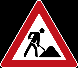

In [118]:
# load
tmp = cv2.imread(tmp_file, cv2.IMREAD_UNCHANGED)

mask = get_mask(tmp)
tmp = cv2.cvtColor(tmp[:,:,:3], cv2.COLOR_BGR2RGB)

# resize
max_size = np.random.randint(50,100)
tmp = A.LongestMaxSize(max_size=max_size)(image=tmp)['image']
mask = A.LongestMaxSize(max_size=max_size)(image=mask)['image']

# brightness
tmp, _, _ = brightness(tmp, alpha=alpha, beta=0)

print(tmp.shape, tmp.dtype, mask.shape, max_size)

T.ToPILImage()(tmp)

In [119]:
# position

max0 = img.shape[0] - tmp.shape[0]
max1 = img.shape[1] - tmp.shape[1]

pos0 = np.random.randint(0, max0 + 1)
pos1 = np.random.randint(0, max1 + 1)

print(pos1, pos0)

608 758


10
(68, 78, 3)


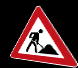

In [120]:
# perspective transformation

tmp, mask, p = perspective(tmp, mask, pos1)

print(p)
print(tmp.shape)

T.ToPILImage()(tmp)

(69, 67, 3)


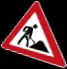

In [121]:
# rotation

tmp, mask, theta = rotate(tmp, mask)

print(tmp.shape)

T.ToPILImage()(tmp)

0.9319700000000001 (64, 62, 3)


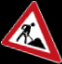

In [122]:
# scale

tmp, mask, factor = scale(tmp, mask, relative_x=abs(2 * pos1 / img.shape[1]))

print(factor, tmp.shape)

T.ToPILImage()(tmp)

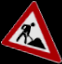

In [123]:
# adjust brightness to background

tmp, mask = remove_padding(tmp, mask) # remove padding

y0 = pos0
y1 = y0 + tmp.shape[0]
x0 = pos1
x1 = x0 + tmp.shape[1]

tmp = brightness_adjust(tmp, mask, img[y0:y1, x0:x1])

T.ToPILImage()(tmp)

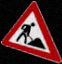

In [124]:
# noise

tmp = uniform_noise(tmp)

T.ToPILImage()(tmp)

box:  [608, 758, 670, 822]


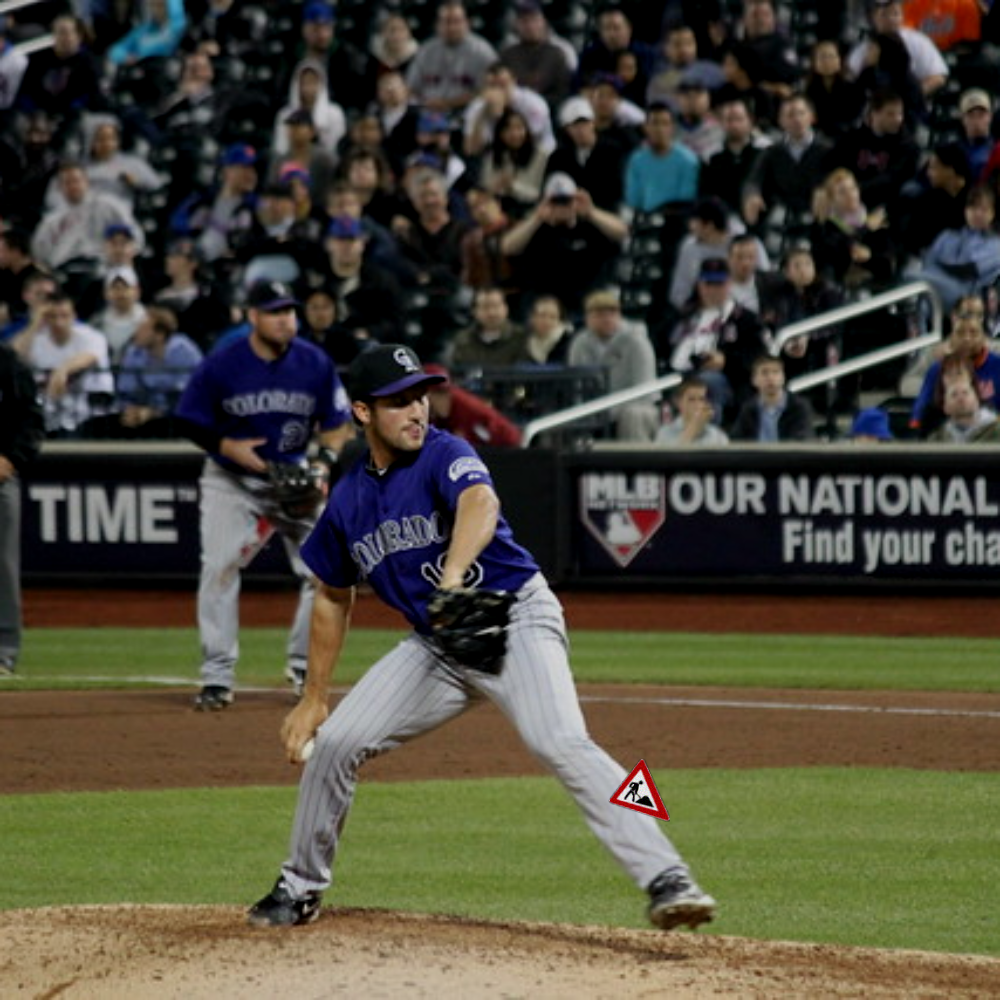

In [125]:
# paste

img = blend(tmp, mask, img, y0, x0)

box = [x0, y0, x1, y1]
print("box: ", box)

T.ToPILImage()(img)

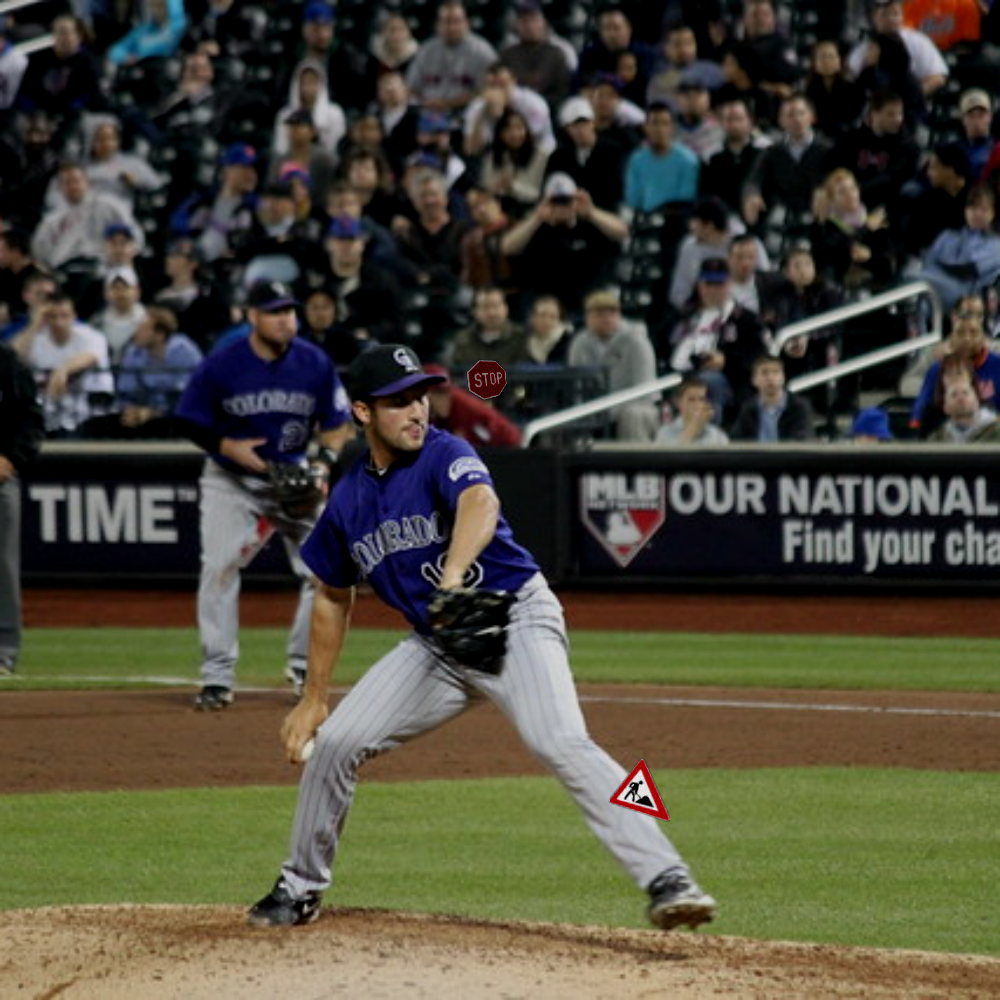

In [126]:
tmp_file = os.path.join(TEMP, temp_files[5])

# load
tmp = cv2.imread(tmp_file, cv2.IMREAD_UNCHANGED)

mask = get_mask(tmp)
tmp = cv2.cvtColor(tmp[:,:,:3], cv2.COLOR_BGR2RGB)

# resize
max_size = np.random.randint(50,100)
tmp = A.LongestMaxSize(max_size=max_size)(image=tmp)['image']
mask = A.LongestMaxSize(max_size=max_size)(image=mask)['image']

# brightness
tmp, _, _ = brightness(tmp, alpha=alpha, beta=0)

# position
max0 = img.shape[0] - tmp.shape[0]
max1 = img.shape[1] - tmp.shape[1]

pos0 = np.random.randint(0, max0 + 1)
pos1 = np.random.randint(0, max1 + 1)


# geometric transformations
tmp, mask, p = perspective(tmp, mask, pos1)
tmp, mask, theta = rotate(tmp, mask)
tmp, mask, factor = scale(tmp, mask, relative_x=abs(2 * pos1 / img.shape[1]))
tmp, mask = remove_padding(tmp, mask) # remove padding

# adjust brightness to background
y0 = pos0
y1 = y0 + tmp.shape[0]
x0 = pos1
x1 = x0 + tmp.shape[1]
tmp = brightness_adjust(tmp, mask, img[y0:y1, x0:x1])

# noise
tmp = uniform_noise(tmp)

# paste
img = blend(tmp, mask, img, y0, x0)

T.ToPILImage()(img)